In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau # Import scheduler
import matplotlib.pyplot as plt
import time
import os
import gc # Garbage collector

# Optional: for progress bars
# try:
#     from tqdm.notebook import tqdm
# except ImportError:
#     def tqdm(iterable, **kwargs):
#         return iterable # Fallback if tqdm not installed

print(f"PyTorch version: {torch.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 1.10.1+cu102
Pandas version: 1.1.5
NumPy version: 1.19.5


In [2]:
# --- File and Path ---
data_filename = 'LD2011_2014.txt'

# --- Subset Configuration ---
# START with a smaller number (e.g., 20-30) to ensure it runs.
# Increase later if memory allows and results improve.
num_clients_subset = 20 # << ADJUST AS NEEDED >>

# --- Feature Engineering ---
# Add '_sin', '_cos' later for cyclical features
original_time_features_base = ['Hour', 'DayOfWeek', 'Month', 'Year', 'DayOfYear', 'WeekOfYear', 'Quarter', 'IsWeekend']
cyclical_cols_to_encode = ['Hour', 'DayOfWeek', 'Month', 'DayOfYear'] # Cols to encode cyclically
# Lags and Rolling Windows
lags_to_create = {'1h': 4, '1d': 96, '1w': 672}
window_sizes = {'24h': 96, '7d': 672}


# --- Data Splitting ---
train_end_date = '2012-12-31 23:45:00'
validation_end_date = '2013-12-31 23:45:00'
# Test set is 2014 onwards

# --- Model & Training ---
sequence_length = 96      # Input sequence length (1 day)
lstm_hidden_size = 48     # << ADJUST: Try slightly smaller? (e.g., 32, 48, 64) >>
lstm_num_layers = 2       # << ADJUST: Try 1 or 2 >>
dropout_rate = 0.3        # << ADJUST: Increased dropout for regularization >>
learning_rate = 0.001     # Initial learning rate
weight_decay = 1e-5       # << ADJUST: Added L2 regularization (e.g., 1e-5, 1e-4) >>
num_epochs = 20           # << ADJUST: Increase epochs slightly, rely on early stopping >>
batch_size = 64           # Adjust based on GPU/CPU memory
patience = 5              # Early stopping patience (increased slightly)
lr_scheduler_factor = 0.1 # Factor to reduce LR by
lr_scheduler_patience = 3 # Patience for LR scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available

print(f"--- Configuration ---")
print(f"Client Subset Size: {num_clients_subset}")
print(f"Sequence Length: {sequence_length}")
print(f"LSTM Hidden Size: {lstm_hidden_size}")
print(f"LSTM Layers: {lstm_num_layers}")
print(f"Dropout Rate: {dropout_rate}")
print(f"Weight Decay: {weight_decay}")
print(f"Initial LR: {learning_rate}")
print(f"Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Early Stopping Patience: {patience}")
print(f"Device: {device}")

--- Configuration ---
Client Subset Size: 20
Sequence Length: 96
LSTM Hidden Size: 48
LSTM Layers: 2
Dropout Rate: 0.3
Weight Decay: 1e-05
Initial LR: 0.001
Epochs: 20
Batch Size: 64
Early Stopping Patience: 5
Device: cpu


In [3]:
print(f"Attempting to load data from: {data_filename}")
start_load_time = time.time()
data = None
try:
    data = pd.read_csv(data_filename, sep=';', low_memory=False)
    print(f"File loaded successfully in {time.time() - start_load_time:.2f} seconds.")
    print(f"Initial data shape: {data.shape}")

    # Rename Timestamp Column
    print(f"Renaming the first column '{data.columns[0]}' to 'Timestamp'...")
    data.rename(columns={data.columns[0]: 'Timestamp'}, inplace=True)

    # Convert Timestamp Column and Set Index
    print(f"Converting 'Timestamp' column to datetime and setting as index...")
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data.set_index('Timestamp', inplace=True)
    # Force frequency if we know it should be complete (might error if gaps exist)
    # data = data.asfreq('15min')
    print(f"Index set. Frequency: {data.index.freq}")

    # Convert Consumption Columns to Numeric & float32
    print(f"Converting consumption columns to numeric (float32)...")
    consumption_cols = data.columns[data.columns.str.startswith('MT_')]
    for col in consumption_cols:
        if not pd.api.types.is_numeric_dtype(data[col]):
             if data[col].dtype == 'object':
                  data.loc[:, col] = data.loc[:, col].astype(str).str.replace(',', '.', regex=False)
             data.loc[:, col] = pd.to_numeric(data.loc[:, col], errors='coerce')
        data.loc[:, col] = data.loc[:, col].astype('float32') # Convert to float32

    print("Numeric conversion and float32 casting finished.")
    print("\nMemory usage after float32 conversion:")
    data.info(memory_usage='deep')
    print("\nChecking for NaNs after initial load/conversion...")
    initial_nans = data.isnull().sum().sum()
    print(f"Total NaNs: {initial_nans}")
    if initial_nans > 0:
        print("Warning: NaNs detected after initial load/conversion. Consider investigating or filling.")
        # data.fillna(0, inplace=True) # Example: Fill with 0 if appropriate

except FileNotFoundError:
    print(f"ERROR: File not found at {data_filename}.")
    data = None
except Exception as e:
    print(f"An error occurred during loading/initial cleaning: {e}")
    data = None

if data is None:
    raise SystemExit("Data loading failed. Stopping execution.")

Attempting to load data from: LD2011_2014.txt
File loaded successfully in 21.63 seconds.
Initial data shape: (140256, 371)
Renaming the first column 'Unnamed: 0' to 'Timestamp'...
Converting 'Timestamp' column to datetime and setting as index...
Index set. Frequency: None
Converting consumption columns to numeric (float32)...
Numeric conversion and float32 casting finished.

Memory usage after float32 conversion:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float32(370)
memory usage: 199.0 MB

Checking for NaNs after initial load/conversion...
Total NaNs: 0


In [4]:
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val).astype('float32') # Use float32
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val).astype('float32') # Use float32
    return df

if data is not None:
    print("\nCreating base time features...")
    start_time_feat = time.time()
    data['Hour'] = data.index.hour
    data['DayOfWeek'] = data.index.dayofweek
    data['Month'] = data.index.month
    data['Year'] = data.index.year
    data['DayOfYear'] = data.index.dayofyear
    data['WeekOfYear'] = data.index.isocalendar().week.astype(int) # Keep as int
    data['Quarter'] = data.index.quarter
    data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0).astype('int8') # Use smaller int type

    print("Encoding cyclical features...")
    # Max values: Hour (0-23 -> 24), DayOfWeek (0-6 -> 7), Month (1-12 -> 12), DayOfYear (1-366 -> 366)
    data = encode_cyclical(data, 'Hour', 24)
    data = encode_cyclical(data, 'DayOfWeek', 7)
    data = encode_cyclical(data, 'Month', 12)
    data = encode_cyclical(data, 'DayOfYear', 366) # Use 366 for leap year safety

    # Define the final list of time-based features to use
    time_features_to_use = [f for f in original_time_features_base if f not in cyclical_cols_to_encode] + \
                           [f + s for f in cyclical_cols_to_encode for s in ['_sin', '_cos']]

    print(f"Time & cyclical features created in {time.time() - start_time_feat:.2f} seconds.")
    print(f"Data shape after adding time features: {data.shape}")
    print(f"Time features being used: {time_features_to_use}")
else:
    print("Skipping time features: Data not loaded.")


Creating base time features...
Encoding cyclical features...
Time & cyclical features created in 0.26 seconds.
Data shape after adding time features: (140256, 386)
Time features being used: ['Year', 'WeekOfYear', 'Quarter', 'IsWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos']


In [5]:
if data is not None:
    print(f"\n--- Processing subset of {num_clients_subset} clients for lags/rolling ---")
    client_subset = data.columns[data.columns.str.startswith('MT_')][:num_clients_subset].tolist()
    print(f"Clients: {client_subset}")

    print("\nCreating features (lags and rolling) for subset...")
    start_time_feat_eng = time.time()
    features_to_add = {}

    for col in client_subset:
        # Lags
        for lag_name, lag_steps in lags_to_create.items():
            lag_col_name = f"{col}_lag{lag_name}"
            data[lag_col_name] = data[col].shift(lag_steps).astype('float32') # Ensure float32
            features_to_add[lag_col_name] = 'lag'
        # Rolling Means
        for window_name, window_steps in window_sizes.items():
            roll_col_name = f"{col}_roll_mean_{window_name}"
            data[roll_col_name] = data[col].rolling(window=window_steps, min_periods=1, closed='left').mean().astype('float32')
            features_to_add[roll_col_name] = 'roll'

    end_time_feat_eng = time.time()
    print(f"Lag/Rolling features created for subset in {end_time_feat_eng - start_time_feat_eng:.2f} seconds.")
    print(f"Data shape after adding subset features: {data.shape}")
    print(f"Number of new lag/roll features added: {len(features_to_add)}")
else:
    print("Skipping subset features: Data not available.")


--- Processing subset of 20 clients for lags/rolling ---
Clients: ['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007', 'MT_008', 'MT_009', 'MT_010', 'MT_011', 'MT_012', 'MT_013', 'MT_014', 'MT_015', 'MT_016', 'MT_017', 'MT_018', 'MT_019', 'MT_020']

Creating features (lags and rolling) for subset...
Lag/Rolling features created for subset in 0.60 seconds.
Data shape after adding subset features: (140256, 486)
Number of new lag/roll features added: 100


In [6]:
if data is not None:
    print("\nSplitting data into train, validation, and test sets...")

    # Define target columns (the clients we are processing)
    target_cols = client_subset
    # Define feature columns (selected time features + newly created lags/rolling for the subset)
    feature_cols = time_features_to_use + list(features_to_add.keys())
    print(f"Total number of feature columns: {len(feature_cols)}")

    # --- Split based on date index ---
    train_data = data.loc[data.index <= train_end_date].copy()
    validation_data = data.loc[(data.index > train_end_date) & (data.index <= validation_end_date)].copy()
    test_data = data.loc[data.index > validation_end_date].copy()

    print(f"Train set shape (before NaN drop): {train_data.shape}")
    print(f"Validation set shape: {validation_data.shape}")
    print(f"Test set shape: {test_data.shape}")

    # --- Handle NaNs (Drop from Training Set ONLY) ---
    print("\nHandling NaNs introduced by feature engineering...")
    initial_train_rows = len(train_data)
    train_data.dropna(subset=feature_cols, inplace=True) # Drop rows in train if ANY feature is NaN
    final_train_rows = len(train_data)
    print(f"Dropped {initial_train_rows - final_train_rows} rows from training set due to NaNs.")
    print(f"Train set shape (after NaN drop): {train_data.shape}")

    # Verify no NaNs left in training features/targets used for modeling
    print(f"NaNs remaining in train_data features: {train_data[feature_cols].isnull().sum().sum()}")
    print(f"NaNs remaining in train_data targets: {train_data[target_cols].isnull().sum().sum()}")

    # Check NaNs in validation/test features - these might need imputation depending on the model needs at inference time
    val_nan_count = validation_data[feature_cols].isnull().sum().sum()
    test_nan_count = test_data[feature_cols].isnull().sum().sum()
    print(f"NaNs in validation features: {val_nan_count}")
    print(f"NaNs in test features: {test_nan_count}")
    # If > 0, may need imputation strategy before prediction if model can't handle NaNs
    # Example: validation_data[feature_cols] = validation_data[feature_cols].fillna(0)

else:
    print("Skipping splitting: Data not available.")


Splitting data into train, validation, and test sets...
Total number of feature columns: 112
Train set shape (before NaN drop): (70175, 486)
Validation set shape: (35040, 486)
Test set shape: (35041, 486)

Handling NaNs introduced by feature engineering...
Dropped 672 rows from training set due to NaNs.
Train set shape (after NaN drop): (69503, 486)
NaNs remaining in train_data features: 0
NaNs remaining in train_data targets: 0
NaNs in validation features: 0
NaNs in test features: 0


In [7]:
if 'train_data' in locals():
    print("\nScaling features...")
    scaler = StandardScaler()

    print("Fitting scaler on training data features...")
    # Ensure only columns present in train_data are used for fitting/transforming
    valid_feature_cols = [col for col in feature_cols if col in train_data.columns]
    if len(valid_feature_cols) != len(feature_cols):
        print("Warning: Some feature columns specified were not found in train_data.")
    scaler.fit(train_data[valid_feature_cols]) # Fit only on available feature columns

    print("Transforming features for train, validation, and test sets...")
    X_train = scaler.transform(train_data[valid_feature_cols]).astype('float32')
    X_val = scaler.transform(validation_data[valid_feature_cols]).astype('float32')
    X_test = scaler.transform(test_data[valid_feature_cols]).astype('float32')

    # Get target variables (ensure float32)
    y_train = train_data[target_cols].values.astype('float32')
    y_val = validation_data[target_cols].values.astype('float32')
    y_test = test_data[target_cols].values.astype('float32')

    # Store feature and target counts for model definition
    num_features = X_train.shape[1]
    num_targets = y_train.shape[1]

    print(f"Scaling complete.")
    print(f"Number of features used for scaling: {num_features}")
    print(f"Number of targets: {num_targets}")
    print(f"Scaled feature shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")
    print(f"Target shapes: y_train={y_train.shape}, y_val={y_val.shape}, y_test={y_test.shape}")

    # --- Optional: Clean up memory ---
    print("Cleaning up intermediate dataframes...")
    del data, train_data, validation_data, test_data
    gc.collect()
    print("Cleanup complete.")

else:
    print("Skipping scaling: Training data not available.")


Scaling features...
Fitting scaler on training data features...
Transforming features for train, validation, and test sets...
Scaling complete.
Number of features used for scaling: 112
Number of targets: 20
Scaled feature shapes: X_train=(69503, 112), X_val=(35040, 112), X_test=(35041, 112)
Target shapes: y_train=(69503, 20), y_val=(35040, 20), y_test=(35041, 20)
Cleaning up intermediate dataframes...
Cleanup complete.


In [8]:
if 'X_train' in locals():
    print("\nSetting up Dataset and DataLoaders...")

    # --- Custom Dataset for On-the-Fly Sequencing ---
    class TimeSeriesSequenceDataset(Dataset):
        def __init__(self, features, targets, seq_length):
            self.features = features
            self.targets = targets
            self.seq_length = seq_length

        def __len__(self):
            return self.features.shape[0] - self.seq_length

        def __getitem__(self, idx):
            feature_sequence = self.features[idx : idx + self.seq_length]
            target_value = self.targets[idx + self.seq_length]
            # Convert slice to tensor here
            return torch.tensor(feature_sequence, dtype=torch.float32), \
                   torch.tensor(target_value, dtype=torch.float32)

    # --- Create Datasets ---
    print("Creating custom datasets...")
    train_dataset_seq = TimeSeriesSequenceDataset(X_train, y_train, sequence_length)
    val_dataset_seq = TimeSeriesSequenceDataset(X_val, y_val, sequence_length)
    test_dataset_seq = TimeSeriesSequenceDataset(X_test, y_test, sequence_length)
    print(f"Train dataset length: {len(train_dataset_seq)}")
    print(f"Validation dataset length: {len(val_dataset_seq)}")
    print(f"Test dataset length: {len(test_dataset_seq)}")

    # --- Create DataLoaders ---
    print("Creating DataLoaders...")
    num_workers_setting = 0 # Start with 0, increase if CPU becomes bottleneck
    train_loader = DataLoader(train_dataset_seq, batch_size=batch_size, shuffle=True, num_workers=num_workers_setting, pin_memory=True if device == 'cuda' else False)
    val_loader = DataLoader(val_dataset_seq, batch_size=batch_size, shuffle=False, num_workers=num_workers_setting, pin_memory=True if device == 'cuda' else False)
    test_loader = DataLoader(test_dataset_seq, batch_size=batch_size, shuffle=False, num_workers=num_workers_setting, pin_memory=True if device == 'cuda' else False)
    print(f"DataLoaders created with batch size {batch_size}.")

    # --- Verify by checking one batch ---
    try:
        print("\nChecking shape of one batch from train_loader:")
        for batch_X, batch_y in train_loader:
            print(f"Sample batch shape: X={batch_X.shape}, y={batch_y.shape}")
            break
    except Exception as e:
        print(f"Error checking batch: {e}")
    print("\n--- Data ready for model input ---")

else:
    print("Skipping Dataset/DataLoader setup: Scaled data not available.")


Setting up Dataset and DataLoaders...
Creating custom datasets...
Train dataset length: 69407
Validation dataset length: 34944
Test dataset length: 34945
Creating DataLoaders...
DataLoaders created with batch size 64.

Checking shape of one batch from train_loader:
Sample batch shape: X=torch.Size([64, 96, 112]), y=torch.Size([64, 20])

--- Data ready for model input ---


In [9]:
class LSTMForecastModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMForecastModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

# --- Instantiate the model ---
if 'num_features' in locals() and 'num_targets' in locals():
    model = LSTMForecastModel(input_size=num_features,
                              hidden_size=lstm_hidden_size,
                              num_layers=lstm_num_layers,
                              output_size=num_targets,
                              dropout_rate=dropout_rate).to(device)

    print("\n--- Model Architecture ---")
    print(model)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,}")
else:
    print("Skipping model instantiation: num_features/num_targets not defined.")


--- Model Architecture ---
LSTMForecastModel(
  (lstm): LSTM(112, 48, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=48, out_features=20, bias=True)
)
Total trainable parameters: 50,900


In [10]:
if 'model' in locals():
    # --- Loss Function ---
    criterion = nn.MSELoss()

    # --- Optimizer ---
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Added weight_decay

    # --- Learning Rate Scheduler ---
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_scheduler_factor,
                                patience=lr_scheduler_patience, verbose=True)

    print("\n--- Training Setup ---")
    print(f"Loss Function: {criterion}")
    print(f"Optimizer: {optimizer}")
    print(f"LR Scheduler: ReduceLROnPlateau(patience={lr_scheduler_patience}, factor={lr_scheduler_factor})")
else:
    print("Skipping training setup: Model not instantiated.")


--- Training Setup ---
Loss Function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-05
)
LR Scheduler: ReduceLROnPlateau(patience=3, factor=0.1)


In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    # dataloader_prog = tqdm(dataloader, desc="Training", leave=False) if 'tqdm' in globals() else dataloader
    for features, targets in dataloader: # dataloader_prog:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        # Optional: torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        # dataloader_prog = tqdm(dataloader, desc="Evaluating", leave=False) if 'tqdm' in globals() else dataloader
        for features, targets in dataloader: # dataloader_prog:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    avg_loss = total_loss / len(dataloader)
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return avg_loss, all_outputs, all_targets


--- Starting Training ---
Epoch [1/20], LR: 0.001000, Train Loss: 3953.833609, Val Loss: 6798.246055, Duration: 295.42s
  Validation loss improved. Saving model to best_lstm_model_subset_v2.pth
Epoch [2/20], LR: 0.001000, Train Loss: 2402.532257, Val Loss: 4450.597064, Duration: 297.42s
  Validation loss improved. Saving model to best_lstm_model_subset_v2.pth
Epoch [3/20], LR: 0.001000, Train Loss: 1532.963452, Val Loss: 3014.100208, Duration: 342.88s
  Validation loss improved. Saving model to best_lstm_model_subset_v2.pth
Epoch [4/20], LR: 0.001000, Train Loss: 1017.723459, Val Loss: 2175.872107, Duration: 346.57s
  Validation loss improved. Saving model to best_lstm_model_subset_v2.pth
Epoch [5/20], LR: 0.001000, Train Loss: 738.605023, Val Loss: 1747.456174, Duration: 342.37s
  Validation loss improved. Saving model to best_lstm_model_subset_v2.pth
Epoch [6/20], LR: 0.001000, Train Loss: 620.918739, Val Loss: 1574.093743, Duration: 358.58s
  Validation loss improved. Saving model 

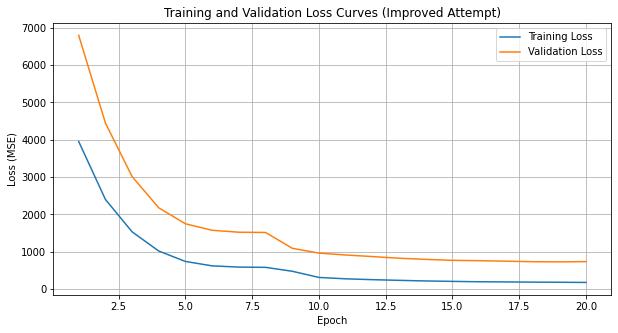

In [12]:
if 'model' in locals() and 'train_loader' in locals() and 'val_loader' in locals():
    print("\n--- Starting Training ---")
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    training_stopped_early = False

    start_training_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        avg_train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(avg_train_loss)

        avg_val_loss, _, _ = evaluate(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)

        # --- Learning Rate Scheduler Step ---
        scheduler.step(avg_val_loss)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        current_lr = optimizer.param_groups[0]['lr'] # Get current learning rate

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"LR: {current_lr:.6f}, "
              f"Train Loss: {avg_train_loss:.6f}, "
              f"Val Loss: {avg_val_loss:.6f}, "
              f"Duration: {epoch_duration:.2f}s")

        # --- Early Stopping & Model Saving ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_lstm_model_subset_v2.pth') # Use a new name
            print(f"  Validation loss improved. Saving model to best_lstm_model_subset_v2.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f"  Early stopping triggered after {patience} epochs without improvement.")
                training_stopped_early = True
                break # Stop Training

    end_training_time = time.time()
    print(f"\nTraining finished in {(end_training_time - start_training_time)/60:.2f} minutes.")
    if training_stopped_early:
        print(f"Training stopped early at epoch {epoch + 1}.")

    # --- Plot Loss Curves ---
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss Curves (Improved Attempt)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Skipping training: Model or DataLoaders not available.")

In [13]:
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > epsilon
    # Handle cases where mask might be empty or all false
    if np.sum(mask) == 0:
        return np.inf # Or some other indicator of invalid MAPE
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

if 'model' in locals() and 'test_loader' in locals():
    print("\n--- Final Evaluation on Test Set ---")
    # Load the best performing model state from the latest training run
    best_model_path = 'best_lstm_model_subset_v2.pth' # <<< Use the new name
    try:
        print(f"Loading best model state from {best_model_path}")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
    except FileNotFoundError:
        print(f"WARNING: {best_model_path} not found. Evaluating with the current model state.")
        best_model_path = None # Flag that we couldn't load
    except Exception as e:
        print(f"Error loading model state from {best_model_path}: {e}. Evaluating with the current model state.")
        best_model_path = None

    # Evaluate on the test set
    test_loss, test_outputs, test_targets = evaluate(model, test_loader, criterion, device)

    print(f"\nTest Set Performance (Model: {'Loaded Best' if best_model_path else 'Current State'}):")
    print(f"  MSE:      {test_loss:.6f}")
    rmse = np.sqrt(test_loss)
    print(f"  RMSE:     {rmse:.6f}")
    mae = mean_absolute_error(test_targets, test_outputs)
    print(f"  MAE:      {mae:.6f}")
    mape = mean_absolute_percentage_error(test_targets, test_outputs)
    print(f"  MAPE:     {mape:.2f}%") # Interpret MAPE carefully

    # Store results for visualization
    y_test_pred = test_outputs
    y_test_true = test_targets

else:
    print("Skipping final evaluation: Model or Test Loader not available.")


--- Final Evaluation on Test Set ---
Loading best model state from best_lstm_model_subset_v2.pth

Test Set Performance (Model: Loaded Best):
  MSE:      1638.958813
  RMSE:     40.484056
  MAE:      20.363834
  MAPE:     50.79%



--- Visualizing Results ---


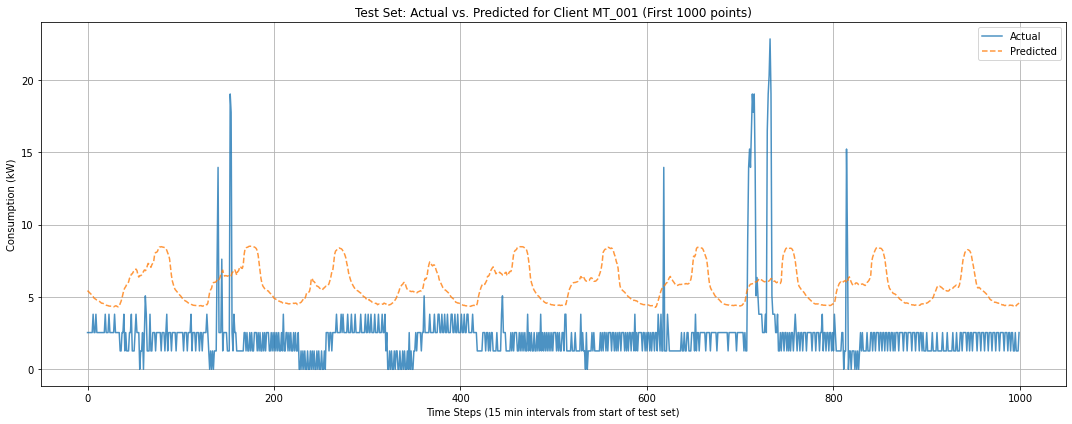

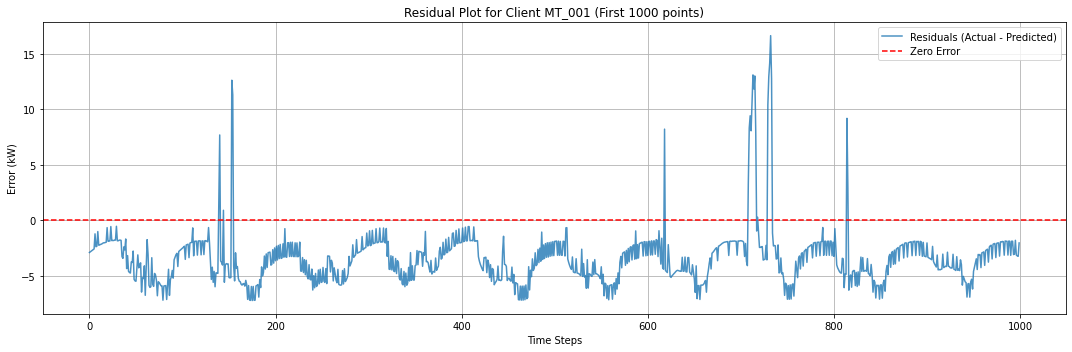

In [14]:
if 'y_test_true' in locals() and 'y_test_pred' in locals():
    print("\n--- Visualizing Results ---")
    client_idx_to_plot = 0 # Choose a client index from the subset (0 to num_clients_subset-1)
    if client_idx_to_plot < len(target_cols):
        client_name = target_cols[client_idx_to_plot]

        plt.figure(figsize=(15, 6))
        plot_slice = 1000 # Plot first N points
        plt.plot(y_test_true[:plot_slice, client_idx_to_plot], label='Actual', alpha=0.8, linewidth=1.5)
        plt.plot(y_test_pred[:plot_slice, client_idx_to_plot], label='Predicted', linestyle='--', alpha=0.8, linewidth=1.5)
        plt.title(f'Test Set: Actual vs. Predicted for Client {client_name} (First {plot_slice} points)')
        plt.xlabel('Time Steps (15 min intervals from start of test set)')
        plt.ylabel('Consumption (kW)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Residual Plot ---
        residuals = y_test_true[:plot_slice, client_idx_to_plot] - y_test_pred[:plot_slice, client_idx_to_plot]
        plt.figure(figsize=(15, 5))
        plt.plot(residuals, label='Residuals (Actual - Predicted)', alpha=0.8)
        plt.axhline(0, color='red', linestyle='--', label='Zero Error')
        plt.title(f'Residual Plot for Client {client_name} (First {plot_slice} points)')
        plt.xlabel('Time Steps')
        plt.ylabel('Error (kW)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Client index {client_idx_to_plot} is out of bounds for the target columns.")

else:
    print("Skipping visualization: Test results not available.")